## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [521]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from io import StringIO
import snipgenie as snpg
import pathogenie as pg
import toytree

In [ ]:
vcf_file='/storage/btbgenie/wicklow_results/filtered.vcf.gz'

In [ ]:
def get_samples_vcf(vcf_file):
    cmd = 'bcftools query -l %s' %vcf_file
    tmp = subprocess.check_output(cmd, shell=True)
    return tmp.decode().split('\n')
    
samplenames = get_samples_vcf(vcf_file)

In [ ]:
path = '/storage/btbgenie/mbovis_ireland/Wicklow/'
files = glob.glob(os.path.join(path,'**', '*.gz'),recursive=True)
samp = snpg.app.get_samples(files,sep='_')
pairs = pd.pivot_table(samp,index=['sample'],columns=['pair'],values='filename',aggfunc='first').reset_index()
print (pairs)

## create reference proteins for MLST

In [ ]:
prots = pg.tools.genbank_to_dataframe('Mbovis-AF212297.2.gb',cds=True)
prots = prots.fillna('')
prots = prots.dropna(subset=['locus_tag'])
ref_proteins = 'Mbovis_AF212297_proteins.fa'
#get prokka type header for using in annotation
prots['header'] = prots.apply(lambda x: '~~~'.join([x.locus_tag,x.gene,x['product'],'none']),1)
pg.tools.dataframe_to_fasta(prots,idkey='header',outfile=ref_proteins)
print (len(prots))

In [ ]:
def get_nucleotide_sequences(gb_file,out_file,idkey='locus_tag'):
    """protein nucleotide seqs from genbank"""
    
    recs = SeqIO.to_dict(SeqIO.parse(gb_file,'genbank'))
    chroms = list(recs.keys())
    for chrom in chroms:
        refrec = recs[chrom]
        result = []
        for f in refrec.features[1:]:
            q=f.qualifiers
            if f.type != 'CDS':
                continue
            seq = refrec.seq[f.location.start:f.location.end]
            try:
                new = SeqRecord(seq,id=q[idkey][0])
                result.append(new)
            except:
                #print (q)
                pass
    SeqIO.write(result,out_file,format='fasta')
    return

get_nucleotide_sequences('Mbovis-AF212297.2.gb','Mbovis_AF212297_nuc.fa')

## assembly

In [ ]:
def spades(file1, file2, path, outfile=None, threads=4):
    """Run spades"""
    
    cmd = 'spades -t %s --pe1-1 %s --pe1-2 %s --careful -o %s' %(threads,file1,file2,path)    
    if not os.path.exists(path): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    if outfile != None:
        shutil.copy(os.path.join(path,'scaffolds.fasta'),outfile)
    return outfile

assembly_path = '/storage/btbgenie/assembly/'

for i,r in pairs[:10].iterrows():    
    name=r['sample']
    print (name)
    out = os.path.join(assembly_path,name+'.fa')
    print (out)
    spades(r[1], r[2], os.path.join(assembly_path,name), outfile=out, threads=10)

## get consensus sequence from alignment instead of assembly

In [ ]:
def get_consensus(vcf_file, sample, out_file):
    """Get consensus sequence from vcf"""
      
    cmd='bcftools index -f %s' %vcf_file
    subprocess.check_output(cmd, shell=True)   
    cmd='cat {r} | bcftools consensus -s {s} {v} > {o}'.format(r=snpg.app.mbovis_genome,v=vcf_file,s=sample,o=out_file)
    #print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

get_consensus(vcf_file, '1034','consensus.fa')

## annotate


In [ ]:
seqfile='/storage/btbgenie/assembly/1034.fa'
#seqfile='consensus.fa'
featdf,recs = pg.run_annotation(seqfile,
                                threads=10, kingdom='bacteria', trusted=ref_proteins)
outfile='/storage/btbgenie/annotation_assembly/1034.fa'

#write out nucl sequences
SeqIO.write(recs,'temp.gb','genbank')
get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')

# initialise MLST table from reference genome

## filter only Mb proteins in scheme

In [ ]:
mlst=pd.read_csv('mlst_scheme.csv')
mlst=mlst[mlst['Ridom Usage']=='MLST+']
targets=list(mlst.Target)

In [ ]:
mbmap=pd.read_csv('final_mbovis_mapping.csv')
mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
mb_tags = list(mbmap.Mb_tag)
prots = prots[prots.locus_tag.isin(mb_tags)]
nucseqs = pg.tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

In [ ]:
cols = ['name','allele','sequence']
ref = nucseqs.copy()
ref['allele'] = 1
ref=ref.rename(columns={'translation':'sequence'})
ref[cols].to_csv('mlst_db.csv.gz',index=False,compression='gzip')
print (len(ref))

In [ ]:
#check a sample against the allele table
fastafile='/storage/btbgenie/annotation/1034.fa'

def find_alleles(fastafile):
    """Find allele by simple matches to the reference table of known sequences.
    Returns:
        dataframe with allele number for each gene
        dataframe with new alleles to add to db
    """
    
    db = pd.read_csv('mlst_db.csv.gz')
    names = ref.name.unique()
    df = pg.tools.fasta_to_dataframe(fastafile)
    result=[]
    new=[]
    for name in names:
        #print (name)
        s = db[db.name==name]
        gene = df[df.name==name]
        if len(gene)==0:
            #print (name)
            continue
        target = gene.iloc[0].sequence
        found = s[s.sequence==target]        
        #print (found)
        if len(found)>0:
            found = found.iloc[0]
            result.append((name,found.allele))
        else:
            #assign new allele
            newallele = s.allele.max()+1
            result.append((name,newallele))
            new.append([name,newallele,target])
    prof = pd.DataFrame(result,columns=['name','allele'])
    prof['allele'] = prof.allele.astype(int)
    new = pd.DataFrame(new,columns=['name','allele','sequence'])
    return prof, new
    
def update_mlst_db(new):
    """Update the database of MLST profiles"""
    
    db = pd.read_csv('mlst_db.csv.gz')
    db = pd.concat([db,new])
    db.to_csv('mlst_db.csv.gz', index=False, compression='gzip')
    print ('added %s new alleles' %len(new))
    return

res,new = find_alleles(fastafile)
print (res)
update_mlst_db(new)

In [ ]:
def type_sample(fastafile, outfile, threads=4, overwrite=False):
    """Type a single sample using wgMLST.
    Args:
        fastafile: fasta file to type from assembly or other
        
        path: output folder for annotations
    Returns:
        dataframe of MLST profile
    """
    
    if overwrite == True or not os.path.exists(outfile):
        #annotate
        featdf,recs = pg.run_annotation(fastafile, threads=threads,
                                        kingdom='bacteria', trusted=ref_proteins)
        #get nucl sequences from annotation    
        SeqIO.write(recs,'temp.gb','genbank')
        get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')
    
    #find alleles
    res,new = find_alleles(outfile)
    #print (res)
    #update db
    update_mlst_db(new)
    return res

#get_consensus(vcf_file, '26-MBovis')
#fastafile = os.path.join(path,'%s.fa' %sample)
sample='1034'
fastafile = os.path.join(assembly_path,'%s.fa' %sample)
res = type_sample(fastafile, '/storage/btbgenie/annotation_assembly/1034.fa', 10)

In [549]:
profs = {}
omit=['182-MBovis','19-4281','19-2438']
samples=glob.glob(os.path.join(assembly_path,'*.fa'))
#print (samples)
for s in samples:
    print (s)
    sample = os.path.splitext(os.path.basename(s))[0]    
    profile = type_sample(f, '/storage/btbgenie/annotation_assembly/%s.fa' %sample, threads=12)
    profs[sample] = get_profile_string(profile)

/storage/btbgenie/assembly/19-11957.fa
added 0 new alleles
/storage/btbgenie/assembly/22-12200.fa
added 0 new alleles
/storage/btbgenie/assembly/13-11594.fa
added 0 new alleles
/storage/btbgenie/assembly/17-MBovis.fa
added 0 new alleles
/storage/btbgenie/assembly/17-11662.fa
added 0 new alleles
/storage/btbgenie/assembly/15-11643.fa
added 0 new alleles
/storage/btbgenie/assembly/19-MBovis.fa
added 0 new alleles
/storage/btbgenie/assembly/182-MBovis.fa
added 0 new alleles
/storage/btbgenie/assembly/14-MBovis.fa
added 0 new alleles
/storage/btbgenie/assembly/1034.fa
added 0 new alleles


## find distances between mlst profiles

In [ ]:
def get_profile_string(df):
    return ''.join(df.allele.astype(str))

In [523]:
def diff_profiles(s1, s2):
    return sum(1 for a, b in zip(list(s1), list(s2)) if a != b)

diff_profiles('AAABBBB','AAABBCC')

2

In [540]:
def dist_matrix(profiles):
    """Distance matrix of a set of profiles"""
    
    dist=[]
    for s in profiles:
        x=profiles[s]
        row=[]
        for s in profiles:
            d = diff_profiles(x,profiles[s])
            row.append(d)
        dist.append(row)
    D = pd.DataFrame(dist,columns=profiles.keys(),index=profiles.keys())
    return D

In [555]:
def tree_from_distmatrix(D):
    from skbio import DistanceMatrix
    from skbio.tree import nj
    ids = list(D.index)
    dm = DistanceMatrix(D.values, ids)
    tree = nj(dm)
    print(tree.ascii_art())
    tree.write(treefile, 'newick')
    return

In [557]:
def tree_from_distance_matrix(X):
    """Distance matrix to phylo tree"""

    from Bio import Phylo
    from Bio.Phylo.TreeConstruction import DistanceMatrix,DistanceTreeConstructor
    from Bio.Cluster import distancematrix

    names = list(X.index)
    if type(X) is pd.DataFrame:
        X = X.values
    mat = distancematrix(X)
    new=[]
    for i in mat:
        new.append(np.insert(i, 0, 0).tolist())

    dm = DistanceMatrix(names,new)
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)
    Phylo.draw_ascii(tree,file=open('temp.txt','w'))
    return tree


Tree(rooted=False)

In [571]:
import random
test = {'A':'111223','B':'111221','C':'211121','D':'211123','E':'212211','F':'211122'}
print (test)
d = dist_matrix(test)
tree_from_distmatrix(d)
#tree = tree_from_distance_matrix(d)

d

{'A': '111223', 'B': '111221', 'C': '211121', 'D': '211123', 'E': '212211', 'F': '211122'}
          /-D
         |
         |          /-C
         |---------|
         |         |          /-E
---------|          \--------|
         |                   |          /-B
         |                    \--------|
         |                              \-A
         |
          \-F


,A,B,C,D,E,F
A,0,1,3,2,4,3
B,1,0,2,3,3,3
C,3,2,0,1,3,1
D,2,3,1,0,4,1
E,4,3,3,4,0,4
F,3,3,1,1,4,0


/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


                    /-19-MBovis
          /--------|
         |         |          /-1034
         |          \--------|
         |                   |          /-14-MBovis
         |                    \--------|
         |                              \-13-11594
         |
         |                    /-17-11662
---------|          /--------|
         |         |          \-22-12200
         |---------|
         |         |          /-19-11957
         |          \--------|
         |                   |          /-182-MBovis
         |                    \--------|
         |                              \-15-11643
         |
          \-17-MBovis


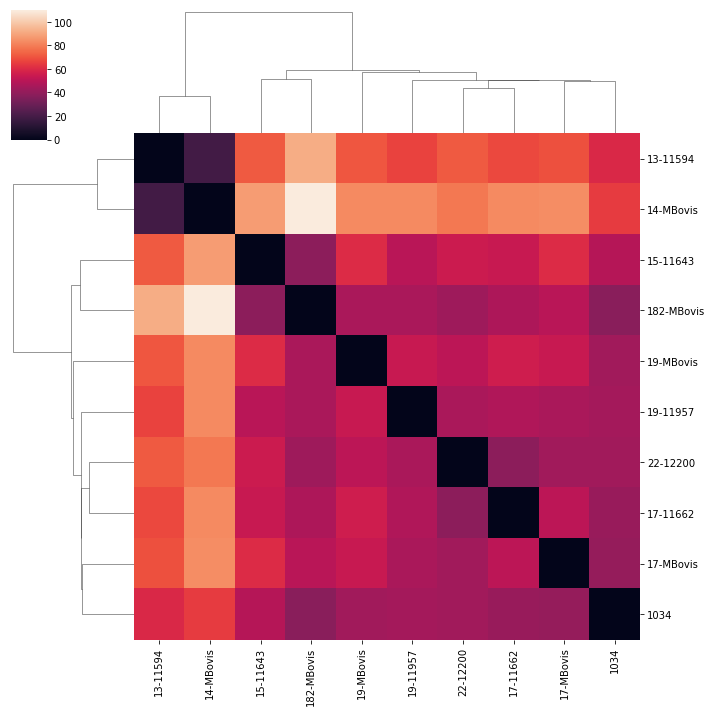

In [572]:
D = dist_matrix(profs)
D.to_csv('dist_mlst.csv',index=False)
sns.clustermap(D,xticklabels=True,yticklabels=True)
tree_from_distmatrix(D)

In [573]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
#mapping = dict(zip(meta['sample'],meta.clade))

tre = toytree.tree(treefile)
tre=tre.root('17-11662')
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="275.0px" viewBox="0 0 500.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t40ed2e24cb1646fda1233f4d44bb48ae"> 13-11594 14-MBovis 1034 19-MBovis 17-MBovis 15-11643 182-MBovis 19-11957 22-12200 17-11662 0 19 37 56 75

In [574]:
tre2 = toytree.tree('/storage/btbgenie/wicklow_results/RAxML_bestTree.variants')
drop = list(set(tre2.get_tip_labels()) - set(tre.get_tip_labels()))
tre2=tre2.drop_tips(drop)
tre2=tre2.root('17-11662')
canvas,t,r=tre2.draw(layout='r',scalebar=True,width=800)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="275.0px" viewBox="0 0 800.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf173427d133547a5a156d9d77290ae33"> 22-12200 19-MBovis 1034 182-MBovis 14-MBovis 19-11957 15-11643 13-11594 17-MBovis 17-11662 0.0 0.1 0.3 0.4 0.6 0.7 0.8 1.0